In [ ]:
# download data: https://drive.google.com/file/d/11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-/view?usp=share_link

# Transfer learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
PATH = 'flower_photos/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 256
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                              PATH,
                                              validation_split=0.2,
                                              subset="training",
                                              seed=123,
                                              image_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [3]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                  PATH,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


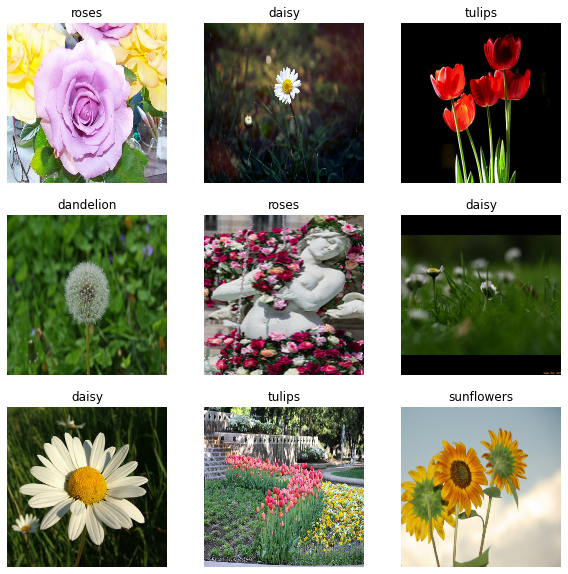

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

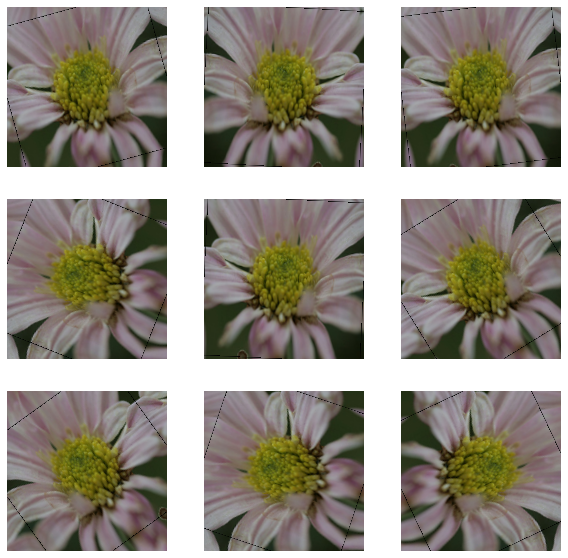

In [7]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [9]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(256, 5, 5, 512)


In [12]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(256, 512)


In [14]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(256, 5)


In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [18]:
len(model.trainable_variables)

2

In [19]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

3/3 [==============================] - 2s 675ms/step - loss: 12.6922 - accuracy: 0.2098
initial loss: 12.69
initial accuracy: 0.21


In [20]:
history = model.fit(train_dataset,
                    epochs=150,
                    validation_data=validation_dataset)

Epoch 1/150
12/12 [==============================] - 5s 397ms/step - loss: 11.8872 - accuracy: 0.1975 - val_loss: 11.6085 - val_accuracy: 0.2289
Epoch 2/150
12/12 [==============================] - 4s 304ms/step - loss: 10.8633 - accuracy: 0.2037 - val_loss: 10.7166 - val_accuracy: 0.2343
Epoch 3/150
12/12 [==============================] - 4s 304ms/step - loss: 10.0949 - accuracy: 0.1894 - val_loss: 9.9830 - val_accuracy: 0.2384
Epoch 4/150
12/12 [==============================] - 4s 313ms/step - loss: 9.6286 - accuracy: 0.2020 - val_loss: 9.3957 - val_accuracy: 0.2411
Epoch 5/150
12/12 [==============================] - 4s 308ms/step - loss: 9.1615 - accuracy: 0.1993 - val_loss: 8.8814 - val_accuracy: 0.2466
Epoch 6/150
12/12 [==============================] - 4s 306ms/step - loss: 8.5757 - accuracy: 0.2142 - val_loss: 8.4289 - val_accuracy: 0.2534
Epoch 7/150
12/12 [==============================] - 4s 305ms/step - loss: 8.1588 - accuracy: 0.2234 - val_loss: 8.0132 - val_accuracy: 0

Epoch 58/150
12/12 [==============================] - 4s 306ms/step - loss: 1.9366 - accuracy: 0.6168 - val_loss: 1.6034 - val_accuracy: 0.6812
Epoch 59/150
12/12 [==============================] - 4s 308ms/step - loss: 1.9123 - accuracy: 0.6124 - val_loss: 1.5824 - val_accuracy: 0.6839
Epoch 60/150
12/12 [==============================] - 4s 315ms/step - loss: 1.9454 - accuracy: 0.6182 - val_loss: 1.5663 - val_accuracy: 0.6866
Epoch 61/150
12/12 [==============================] - 4s 308ms/step - loss: 1.9649 - accuracy: 0.6069 - val_loss: 1.5532 - val_accuracy: 0.6921
Epoch 62/150
12/12 [==============================] - 4s 306ms/step - loss: 1.8591 - accuracy: 0.6339 - val_loss: 1.5372 - val_accuracy: 0.6921
Epoch 63/150
12/12 [==============================] - 4s 307ms/step - loss: 1.8083 - accuracy: 0.6274 - val_loss: 1.5216 - val_accuracy: 0.6935
Epoch 64/150
12/12 [==============================] - 4s 310ms/step - loss: 1.8771 - accuracy: 0.6172 - val_loss: 1.5067 - val_accuracy:

Epoch 115/150
12/12 [==============================] - 4s 307ms/step - loss: 1.2036 - accuracy: 0.7228 - val_loss: 1.0929 - val_accuracy: 0.7561
Epoch 116/150
12/12 [==============================] - 4s 304ms/step - loss: 1.1499 - accuracy: 0.7241 - val_loss: 1.0874 - val_accuracy: 0.7575
Epoch 117/150
12/12 [==============================] - 4s 306ms/step - loss: 1.1479 - accuracy: 0.7248 - val_loss: 1.0835 - val_accuracy: 0.7602
Epoch 118/150
12/12 [==============================] - 4s 309ms/step - loss: 1.1239 - accuracy: 0.7210 - val_loss: 1.0807 - val_accuracy: 0.7589
Epoch 119/150
12/12 [==============================] - 4s 305ms/step - loss: 1.1610 - accuracy: 0.7265 - val_loss: 1.0747 - val_accuracy: 0.7602
Epoch 120/150
12/12 [==============================] - 4s 305ms/step - loss: 1.0424 - accuracy: 0.7442 - val_loss: 1.0734 - val_accuracy: 0.7602
Epoch 121/150
12/12 [==============================] - 4s 307ms/step - loss: 1.1713 - accuracy: 0.7326 - val_loss: 1.0695 - val_ac

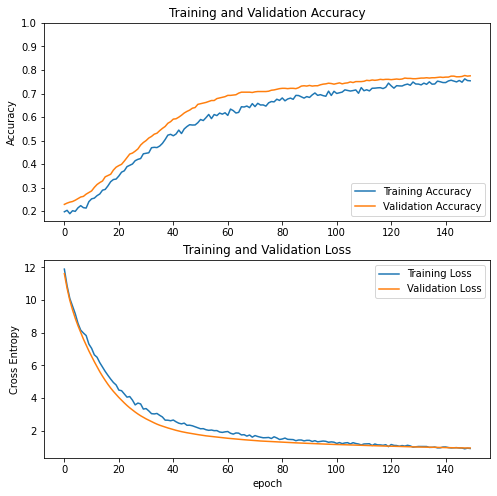

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()